 use the %autoreload magic command to automatically reload modules before executing user code. 
 %autoreload 2 reloads all modules (except those excluded by %aimport) every time before executing the Python code typed.

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Add exceptions for packages to not automatic reload

In [67]:
%aimport -pandas, -numpy, -matplotlib.pyplot, -seaborn, -os, -sys -PIL.Image

Group your import statements here

In [68]:
# General libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
from PIL import Image

# Custom scripts here
# Add the 'scripts' directory to the Python path
scripts_path = os.path.abspath('../scripts')
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from scripts import my_scripts as ms

Example how to call your custom scripts

In [69]:
ms.hello_world()

'Hello, world from you library!'

Read the settings.json file and extract to variables


In [70]:
# Construct the path to the settings.json file
settings_path = os.path.join(os.path.dirname(os.getcwd()), 'settings.json')

# Read the JSON file
with open(settings_path, 'r') as file:
    settings = json.load(file)

# Accessing data from the JSON file
input_dir = ms.create_path_for_notebook(settings['data']['input-directory'])
intermediate_dir = ms.create_path_for_notebook(settings['data']['intermediate-directory'])
output_dir = ms.create_path_for_notebook(settings['data']['output-directory'])
assignment_image_path = ms.transform_path_crossplatform(os.path.join(input_dir, str(settings['data']['assignment_image'])))

# Print the paths to verify
print("input Directory:", input_dir)
print("intermediate Directory:", intermediate_dir)
print("output Directory:", output_dir)
print("assignment image:", assignment_image_path)

input Directory: ..\data\input
intermediate Directory: ..\data\intermediate
output Directory: ..\data\output
assignment image: ..\data\input\image_raw.png


Read the assignment image and display it

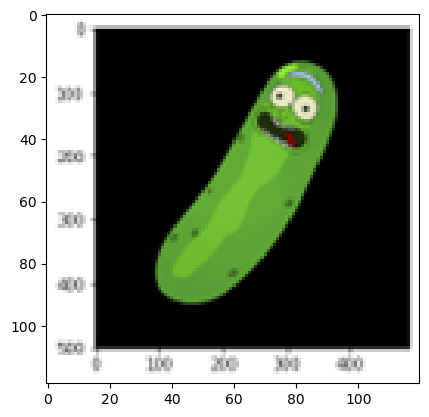

[[0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2], [3, 3, 3, 3, 3, 3, 3]]


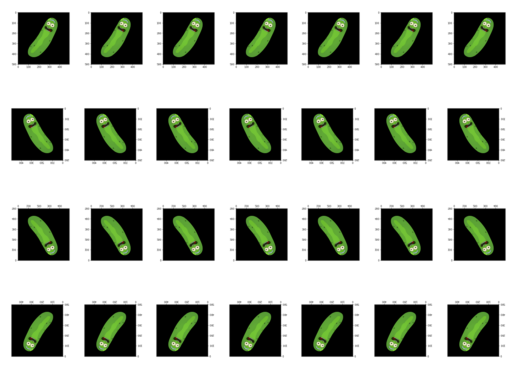

In [85]:
np_assignment_image = ms.read_image_and_convert_to_np_array(assignment_image_path)
ms.convert_np_array_and_show_image_to_plt(np_assignment_image)

# TODO -  select part of the image

# Define the matrix for flips
flip_matrix = [[i for _ in range(7)] for i in range(4)]
print(flip_matrix)

# Call the function
ms.grid_with_flips(np_assignment_image, flip_matrix)

(96, 90, 4)


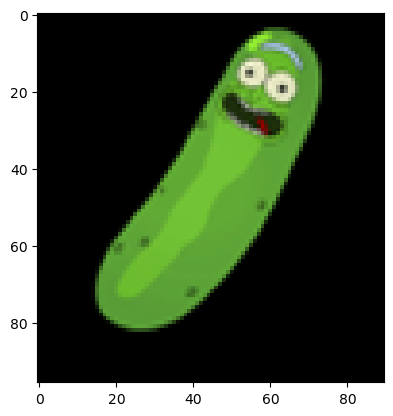

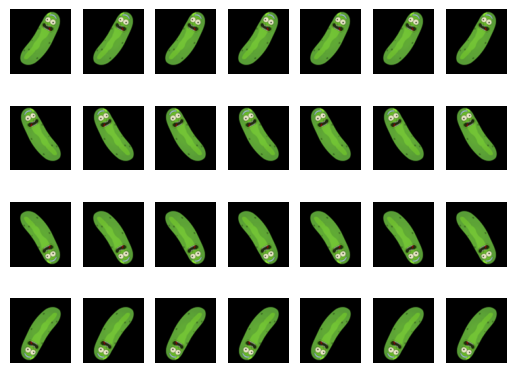

In [104]:

cut_image = np_assignment_image[11:-12, 20:-10]
# Ensure the image data is between 0 and 255 (as uint8 data type represents 8-bit colors)
cut_image = np.clip(cut_image * 255, 0, 255)

# Convert to uint8 data type
cut_image = cut_image.astype(np.uint8)

print(cut_image.shape)

# Save the cut image back to disk
cut_image_path = os.path.join(intermediate_dir, 'cut_image.png')
Image.fromarray(cut_image).save(cut_image_path)

# Show the cut image in the Jupyter notebook interface
ms.convert_np_array_and_show_image_to_plt(cut_image)
ms.grid_with_flips(cut_image, flip_matrix)